In [ ]:
import os
from pathlib import Path
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio as rio
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

Example workflow on how to get data from Paituli STAC and use it for species distribution modelling.

# Acquiring data from Paituli STAC

In [ ]:
import stackstac
from dask.distributed import Client, Lock
import pystac_client
import pyproj
import geopandas as gpd
import json
import requests 
import rioxarray

Paituli STAC only works with `pystac_client` version 0.6.1 so ensure that we are using it.

In [ ]:
pystac_client.__version__

'0.6.1'

First set url for Paituli STAC and create a bugfix exclusive for this

In [ ]:
def change_to_https(request:requests.Request) -> requests.Request:
    request.url = request.url.replace('http:', 'https:')
    return request

paituli_stac_url = 'https://paituli.csc.fi/geoserver/ogc/stac/v1'

Next step is to start a Dask cluster for faster processing

In [ ]:
client = Client(n_workers=20)

Then define the endpoint and see how many collections are in the catalog:

In [ ]:
catalog = pystac_client.Client.open(paituli_stac_url, request_modifier=change_to_https)
catalog

<Client id=GeoserverSTACLandingPage>

In [ ]:
print(f'There are {len(list(catalog.get_collections()))} collections in Paituli STAC')

There are 124 collections in Paituli STAC


Available collections can be browsed [here](https://radiantearth.github.io/stac-browser/#/external/paituli.csc.fi/geoserver/ogc/stac/v1?.language=en). As this example is about modelling the distribution of *Accipiter gentilis*, select suitable layers for that. First chech what kind of canopy related layers there are:

In [ ]:
for collection in catalog.get_collections(): 
    if 'canopy' in collection.id: print(collection.id)

canopy_height_model_at_fmi
canopy_cover_at_geocubes


As `canopy_height_model_at_fmi` only covers the southern part of Finland, we use the `canopy_cover_at_geocubes`.

In [ ]:
canopy_layers = ['canopy_cover_at_geocubes']

Forest related layers might also be useful:

In [ ]:
for collection in catalog.get_collections():
    if 'forest' in collection.id: print(collection.id)

forest_inventory_land_class_at_geocubes
luke_forest_snow_damage_risk_at_paituli
hy_spectre_2_1_forest_loss_perc_at_paituli
forest_inventory_volume_spruce_at_geocubes
forest_inventory_at_fmi
forest_stand_class_at_geocubes
forest_inventory_site_main_class_at_geocubes
hy_spectre_2_2_forest_trend_at_paituli
forest_inventory_site_fertility_class_at_geocubes
forest_inventory_volume_pine_at_geocubes
luke_forest_wind_damage_sensitivity_at_paituli
forest_inventory_volume_of_growing_stock_at_geocubes
forest_inventory_volume_birch_at_geocubes
forest_inventory_volume_of_other_deciduous_tree_at_geocubes
forest_inventory_basal_area_at_geocubes
forest_wind_damage_risk_at_fmi


Most of the above are based on Multi-Source National Forest Inventory by LUKE. We will use those that are present in geocubes as they already have suitable resolutions.

In [ ]:
forest_layers = ['forest_inventory_land_class_at_geocubes', 'forest_inventory_volume_spruce_at_geocubes', 'forest_stand_class_at_geocubes',
                 'forest_inventory_site_main_class_at_geocubes', 'forest_inventory_site_fertility_class_at_geocubes', 
                 'forest_inventory_volume_pine_at_geocubes', 'forest_inventory_volume_of_growing_stock_at_geocubes',
                 'forest_inventory_volume_birch_at_geocubes', 'forest_inventory_volume_of_other_deciduous_tree_at_geocubes',
                 'forest_inventory_basal_area_at_geocubes']

Next check which Sentinel-2 products we have:

In [ ]:
for collection in catalog.get_collections():
    if 'sentinel' in collection.id: print(collection.id)

sentinel_1_11_days_mosaics_at_fmi
sentinel_2_nir_b08_at_geocubes
sentinel_2_satellite_image_mosaic_at_geocubes
sentinel2-l2a
sentinel_2_annual_mosaics_at_fmi
sentinel_2_monthly_index_mosaics_at_fmi
sentinel_1_daily_mosaics_at_fmi
sentinel_1_tiles_at_fmi
sentinel_2_swir_b11_at_geocubes
sentinel_2_11_days_mosaics_at_fmi


`sentinel_2_monthly_index_mosaics_at_fmi` contain monthly index mosaics for NDVI, NDBI, NDSI, NDTI and NDMI. We will use some of those.

In [ ]:
sentinel_layers = ['sentinel_2_monthly_index_mosaics_at_fmi']

There are other useful layers (temperature, precipitation, Corine) but the above should be enough for example purposes.

As all data is limited to Finland, get Finnish borders to intersect it with:

In [ ]:
fin_borders_4326 = gpd.read_file('../data/fin_borders.shp').to_crs('EPSG:4326').geometry.iloc[0]

Search all above collections from the catalog:

In [ ]:
gc_search = catalog.search(
    intersects=fin_borders_4326,
    collections=canopy_layers+forest_layers
)
gc_search.matched()

1200

In [ ]:
# ItemCollection as GeoJson 
gc_stac_json = gc_search.item_collection_as_dict()

# Add Item ID to properties to have access to it in GeoPandas
for a in gc_stac_json['features']:
    a['properties']['title']=a['id']

# GeoJson as GeoPandas dataframe
gc_gdf = gpd.GeoDataFrame.from_features(gc_stac_json, "epsg:4326")
print('Found items: ' "{}".format(len(gc_gdf))) 

Found items: 1200


The large number of matched items is due to geocubes data being tiled.

Go through the Geocubes collections, aggregate them to 100m resolution and save them. First process canopy cover percentage as it is only tiled and doesn't have temporal dimension:

In [ ]:
search = catalog.search(
    intersects=fin_borders_4326,
    collections=canopy_layers
)

# Stack into cube
cube = stackstac.stack(
    items=search.item_collection(),
    epsg=3067,
    resolution=100
).squeeze()

# Mosaic the data

mos = stackstac.mosaic(cube)
mos.sel(band='100m').rio.to_raster('../data/stac/canopy_cover_at_geocubes_100m.tif')

Next go through the forest layers. There are data from 2009 and 2015 so save them separately:

In [ ]:
for c in tqdm(forest_layers):
    search = catalog.search(
        intersects=fin_borders_4326,
        collections=[c]
    )

    cube = stackstac.stack(
        items=search.item_collection(),
        epsg=3067,
        resolution=100
    ).squeeze()

    for t in np.unique(cube.time):
        year = str(t).split('-')[0]
        if not os.path.exists(f'../data/stac/{c}_{year}_100m.tif'):
            mos= stackstac.mosaic(
                cube.sel(time=t)
            )
            mos.sel(band='100m').rio.to_raster(f'../data/stac/{c}_{year}_100m.tif')


100%|██████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]


Final step is to process monthly Sentinel-2 index mosaics. Here we use NDVI only

In [ ]:
search = catalog.search(
    intersects=fin_borders_4326,
    collections=sentinel_layers
)

cube = stackstac.stack(
    items=search.item_collection(),
    epsg=3067,
    resolution=100,
    bounds_latlon=fin_borders_4326.bounds,
    dtype=np.uint8,
    fill_value=0
).squeeze().sel(band='ndvi')

Resample the data to yearly maximum. Mean or median might be better but let's try maximum for example purposes.

In [ ]:
yearly = cube.resample(time='YS').max('time', keep_attrs=True)
yearly

<xarray.DataArray 'stackstac-290ae1af320d8064740e1b17da4625ee' (time: 8,
                                                                y: 11963,
                                                                x: 7081)>
dask.array<stack, shape=(8, 11963, 7081), dtype=uint8, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
    band            <U4 'ndvi'
  * x               (x) float64 5.18e+04 5.19e+04 ... 7.597e+05 7.598e+05
  * y               (y) float64 7.796e+06 7.796e+06 ... 6.6e+06 6.6e+06
    gsd             float64 10.0
    proj:transform  object {0, 1, 7800000, 10, 50000, -10}
    proj:epsg       int64 3067
    title           <U4 'ndvi'
    epsg            int64 3067
  * time            (time) datetime64[ns] 2016-01-01 2017-01-01 ... 2023-01-01
Attributes:
    spec:        RasterSpec(epsg=3067, bounds=(51800, 6599500, 759900, 779580...
    crs:         epsg:3067
    transform:   | 100.00, 0.00, 51800.00|\n| 0.00,-100.00, 7795800.00|\n| 0....
    resolution:  100

In [ ]:
for i, t in enumerate(np.unique(yearly.time)):
    year = str(t).split('-')[0]
    print(year)
    if os.path.exists(f'../data/stac/ndvimax_{year}_100m.tif'): continue
    tif = yearly.isel(time=i).rio.to_raster(
        f'../data/stac/ndvimax_{year}_100m.tif',
        lock=Lock(name="rio", client=client),
        tiled=True,
    )

No more Dask needed, close the client.

In [ ]:
client.close()

Now we have the data, let's use them.

# Using `elapid` for species distribution modelling

In [ ]:
import elapid as ela
from sklearn import metrics
import matplotlib as mpl
import matplotlib.pyplot as plt



First we need to tell where the data can be found

In [ ]:
datapath = Path('../data/stac')

layers = [datapath/f for f in os.listdir(datapath)]
labels = [l.stem for l in layers]

layers

[PosixPath('../data/stac/forest_inventory_basal_area_at_geocubes_2009_100m.tif'),
 PosixPath('../data/stac/forest_inventory_basal_area_at_geocubes_2015_100m.tif'),
 PosixPath('../data/stac/forest_inventory_land_class_at_geocubes_2009_100m.tif'),
 PosixPath('../data/stac/forest_inventory_land_class_at_geocubes_2015_100m.tif'),
 PosixPath('../data/stac/forest_inventory_site_fertility_class_at_geocubes_2009_100m.tif'),
 PosixPath('../data/stac/forest_inventory_site_fertility_class_at_geocubes_2015_100m.tif'),
 PosixPath('../data/stac/forest_inventory_site_main_class_at_geocubes_2009_100m.tif'),
 PosixPath('../data/stac/forest_inventory_site_main_class_at_geocubes_2015_100m.tif'),
 PosixPath('../data/stac/forest_inventory_volume_birch_at_geocubes_2009_100m.tif'),
 PosixPath('../data/stac/forest_inventory_volume_birch_at_geocubes_2015_100m.tif'),
 PosixPath('../data/stac/forest_inventory_volume_of_growing_stock_at_geocubes_2009_100m.tif'),
 PosixPath('../data/stac/forest_inventory_volume_of

Mask all areas outside of the Finnish borders from these data:

In [ ]:
import rasterio.mask as rio_mask

fin_borders_3067 = gpd.read_file('../data/fin_borders.shp')

for l in tqdm(layers):
    with rio.open(l) as src:
        out_im, out_tfm = rio_mask.mask(src, [fin_borders_3067.geometry.iloc[0]], crop=True)
        out_meta = src.meta
    out_meta.update({'driver': 'GTiff',
                     'height': out_im.shape[1],
                     'width': out_im.shape[2],
                     'transform':out_tfm})
    with rio.open(l, 'w', **out_meta) as dest:
        dest.write(out_im)

100%|███████████████████████████████████████████████████████████████████| 28/28 [01:53<00:00,  4.07s/it]


Some of these layers are categorical

In [ ]:
cat_features = [
    'forest_inventory_land_class_at_geocubes_2009_100m',
    'forest_inventory_land_class_at_geocubes_2015_100m',
    'forest_stand_class_at_geocubes_2022_100m',
    'forest_inventory_site_main_class_at_geocubes_2009_100m',
    'forest_inventory_site_main_class_at_geocubes_2015_100m'
]

Then read our species data and rename species

In [ ]:
bird_data = gpd.read_file('../data/birds.geojson')
sp_dict = {'DENMIN': 'Dryobates minor',
           'ACCGEN': 'Accipiter gentilis',
           'BUTBUT': 'Buteo buteo',
           'DENLEU': 'Dendrocopos leucotos',
           'PERAPI': 'Pernis apivorus',
           'PICTRI': 'Picoide tridactylus'}
bird_data['species'] = bird_data.species.apply(lambda row: sp_dict[row])
bird_data['species'].value_counts()

Accipiter gentilis      4219
Buteo buteo             2070
Pernis apivorus          416
Picoide tridactylus      204
Dendrocopos leucotos     182
Dryobates minor          123
Name: species, dtype: int64

As we have the most data for Accipiter gentilis, use that for example

<Axes: >

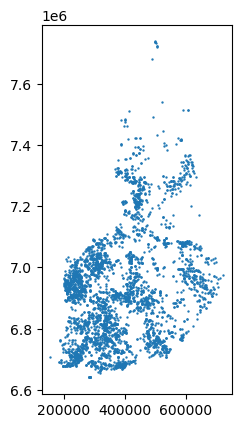

In [ ]:
accip_data = bird_data[bird_data.species == 'Accipiter gentilis']
accip_data.plot(markersize=0.5)

Here we run two tests: one without sampling bias for pseudoabsence and one with it.

First without:

<Axes: >

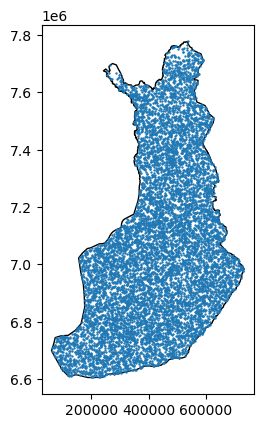

In [ ]:
pseudoabsence = ela.sample_raster(layers[0], count=10000, nodata=0)
fig, ax = plt.subplots(1,1)
fin_borders_3067.plot(facecolor='none', ax=ax)
pseudoabsence.plot(markersize=0.5, ax=ax)

In [ ]:
accip_locs = accip_data.geometry
accip_presence = ela.annotate(accip_locs, layers, labels=labels, drop_na=True)
background = ela.annotate(pseudoabsence, layers, labels=labels, drop_na=True)

Raster:   0%|                              | 0/27 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Raster:   0%|                              | 0/27 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

In [ ]:
accip_presence.dropna(inplace=True)
background.dropna(inplace=True)

Around 15k points annotated from 27 rasters in less than 1.5 minutes. Next make the models, use similar hyperparameters than Maxent software. Hinge features are excluded due to a slight bug: "covariates with all zeros lead to divide-by-zero errors during hinge feature calculations."

In [ ]:
accip_presence.shape, background.shape

((4071, 28), (6683, 28))

In [ ]:
maxent = ela.MaxentModel(transform='cloglog', 
                         beta_lqp=0.05, 
                         beta_hinge=0.5,
                         beta_categorical=0.25,
                         beta_threshold=1.0,
                         feature_types=['linear', 'product'],
                         use_lambdas='best',
                         beta_multiplier=1.5,
                        )

train = ela.stack_geodataframes(accip_presence, background, add_class_label=True)

xtrain = train[labels]
ytrain = train['class']

maxent.fit(xtrain, ytrain, categorical=[i for i in range(len(labels)) if labels[i] in cat_features])

MaxentModel(beta_categorical=0.25, beta_hinge=0.5, beta_lqp=0.05,
            feature_types=['linear', 'product'])

In [ ]:
ypred = maxent.predict(xtrain)
auc = metrics.roc_auc_score(ytrain, ypred)
print(f"Training AUC score: {auc:0.3f}")

Training AUC score: 0.823


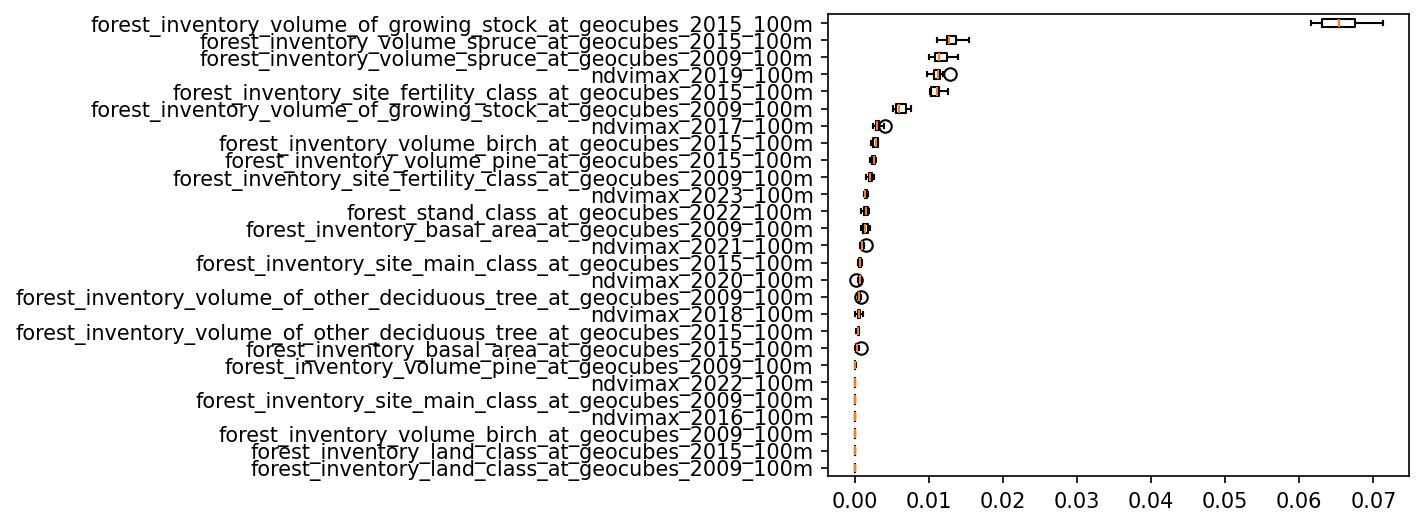

In [ ]:
fig, ax = maxent.permutation_importance_plot(x=xtrain, y=ytrain, labels=labels)

In [ ]:
output = 'accgen_example_nobias.tif'

ela.apply_model_to_rasters(maxent, layers, output, quiet=False)

Window:   0%|                              | 0/11708 [00:00<?, ?it/s]

Now the same process with biased sampling

<Axes: >

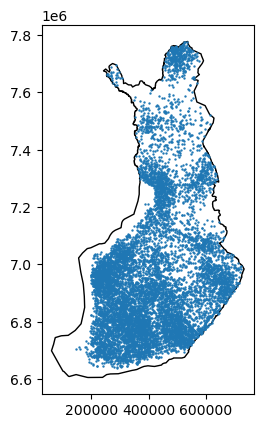

In [ ]:
pseudoabsence_bias = ela.sample_bias_file('../data/Bias_Heini_vajaa_100km.tif', 10_000)
fig, ax = plt.subplots(1,1)
fin_borders_3067.plot(facecolor='none', ax=ax)
pseudoabsence_bias.plot(markersize=0.5, ax=ax)

In [ ]:
background_bias = ela.annotate(pseudoabsence_bias, layers, labels=labels, drop_na=True)
background_bias.dropna(inplace=True)

Raster:   0%|                              | 0/27 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

In [ ]:
maxent = ela.MaxentModel(transform='cloglog', 
                         beta_lqp=0.05, 
                         beta_hinge=0.5,
                         beta_categorical=0.25,
                         beta_threshold=1.0,
                         feature_types=['linear', 'product'],
                         use_lambdas='best',
                         beta_multiplier=1.5,
                        )

train = ela.stack_geodataframes(accip_presence, background_bias, add_class_label=True)

xtrain = train[labels]
ytrain = train['class']

maxent.fit(xtrain, ytrain, categorical=[i for i in range(len(labels)) if labels[i] in cat_features])

MaxentModel(beta_categorical=0.25, beta_hinge=0.5, beta_lqp=0.05,
            feature_types=['linear', 'product'])

Evaluate

In [ ]:
ypred = maxent.predict(xtrain)
auc = metrics.roc_auc_score(ytrain, ypred)
print(f"Training AUC score: {auc:0.3f}")

Training AUC score: 0.758


In [ ]:
output = 'accgen_example_bias.tif'

ela.apply_model_to_rasters(maxent, layers, output, quiet=False)

Window:   0%|                              | 0/11708 [00:00<?, ?it/s]

Aside from Maxent, it is also possible to use other Scikit-learn models. For example, their tutorial uses `svm.OneClassSVM`, but `RandomForestClassifier` or `HistGradientBoostingClassifier` can also be used thanks to consistent API. Use the latter because it handles NaN values.

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [ ]:
gbm = HistGradientBoostingClassifier(categorical_features=[i for i in range(len(labels)) if labels[i] in cat_features],
                                     scoring='roc_auc')
gbm.fit(xtrain, ytrain)
print(f'Validation ROC AUC is {gbm.validation_score_}')

Validation ROC AUC is [0.5        0.75719035 0.76568223 0.77051474 0.77058393 0.7721553
 0.77294253 0.77436322 0.77571934 0.77728149 0.7794233  0.77962933
 0.7817696  0.78214322 0.7822324  0.78291353 0.7843865  0.78530903
 0.78615468 0.78723866 0.78748928 0.78815503 0.78838105 0.78889306
 0.78967413 0.78911139 0.78898685 0.78977715 0.78956804 0.78881464
 0.78901452 0.78945734 0.78920825 0.78884539 0.7881412  0.78815042
 0.78849637 0.78851175]


In [ ]:
ela.apply_model_to_rasters(gbm, layers, 'accgen_gbm_bias.tif', predict_proba=True, count=2)

Window:   0%|                              | 0/11708 [00:00<?, ?it/s]